# Deep Learning vs Traditional ML (Logistic Regression) Camprison Notebook

Now that we have trained various LTSM with up to 2 million samples on Google Colab, we are going to compare the results with our traditional ML model (Logistic Regression)

We know that Logistic Regression's performance plateaus after about 200k samples and we know that LSTM is not performing as well as Logistic Regression with only 200k samples. 2 million is around the limit where we can use Google Colab to train our models while still working within the 24 hour backend limit. Further training for LSTM will probably have to be done on GCP using one of the GPU based compute instances.



## Traditional ML Model

* Model: Logistic Regression
* Class weights: balanced
* Features: TF-IDF with 4k features
    * remove top words
    * lemmatize words
    * remove all HTML tags
    * punchuations are removed
    * contractions are expanded
* Sample Size: 50k to 9mil

## LSTM Models

| LSTM Units | Dropout | Spatial Dropout | Batch Size | Learning Rate | Sample Size |
|------------|---------|-----------------|------------|---------------|-------------|
| 128 | 0 | 0 | 128 | 0.001 | 500k and 1mil |



* GloVe Embeding Size: 300
* Max Epoch: Up to 20
* Early Stop Patience: 4

    
# Conclusion

* LSTM in general is performing better than Logistic Regression
    * After just 200k examples, LSTM performance is already exceeding LR performance after 200k samples
* We see that recall for our minority classes increase as we increase the number of training examples



In [2]:
# import sibling utilities
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import importlib
import os
import pickle
import importlib

import util.dict_util as du
import util.report_util as ru
import util.plot_util as pu

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set(font_scale=2)


/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load PySpark LR Report

In [3]:
# load report file form all of our deep learning models
REPORT_DIR = "../reports"
REPORT_LR = f'{REPORT_DIR}/201911-pyspark-report.csv'


report_lr = pd.read_csv(REPORT_LR, quotechar="'")
# flatten out classification report so we can graph later
report_lr = ru.convert_dnn_report_format(report_lr)

# calculate our custom score
report_lr["eval_metric"] = report_lr.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))


## Load results from 2 LSTM networks with the best scores

In [7]:
# LSTMB128_DR0_RDR20_BATCH32_LR01 - TODO
# TODO: retrain 500k samples - 6.9.1.4-LSTMB128-GloVe_with_stop_nonlemmatized-500k-prototype.csv
report_lstmb128_dr0_rdr20_batch32_lr001 = ru.load_dnn_report(REPORT_DIR, 
                                                            'LSTMB128_dr0_rdr20_batch32_lr001-glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                           convert_format = True)


# LSTMB128_DR0_RDR20_BATCH32_LR01
# 6.9.8.4-LSTMB128_dr0_rdr20_batch128_lr01-glove_with_stop_nonlemmatized-500k-prototype.ipynb
report_lstmb128_dr0_rdr20_batch32_lr01 = ru.load_dnn_report(REPORT_DIR,
                                                            'LSTMB128_dr0_rdr2_batch32_lr01-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                            convert_format = True)



# Model Accuracy and Custom Score

### Accuracy

Accuracy = Number of Correct Predictions / Total Number of Predictions

When looking at accuracy, our small LSTM models actually performed better than LR as well as LSTM with 128 cells. However, this is misleading since these models tends to predict results into majority class and does not take into account behavior for minority classes since our sample distribution skews heavily towards 5-star reviews.

We want to look at more granular metric that takes into account recall and precision for various classes to get a better sense of how the models are doing

### Custom Score

Initial runs of our model tells us that precision and recall for 1-star and 5-star reviews are generally high. However, minority classes (2, 3, 4) generally has low recall.

We want the custom metric to take this into account and help us identify models that balances between precision for majority classes and increase recall for minority classes.

We define our custom metric as the harmonic mean of minority class recall (1-star recall, 2-star recall, 3-star recall, 4-star recall) and 5-star precision

Once we take these into account, you see that LSTM start out performing roughly the same as Logistic Regression with 128 cells. However, it quickly out performs all models with only 500k samples.

* 128 cell networks did better than 16 cell networks
* 


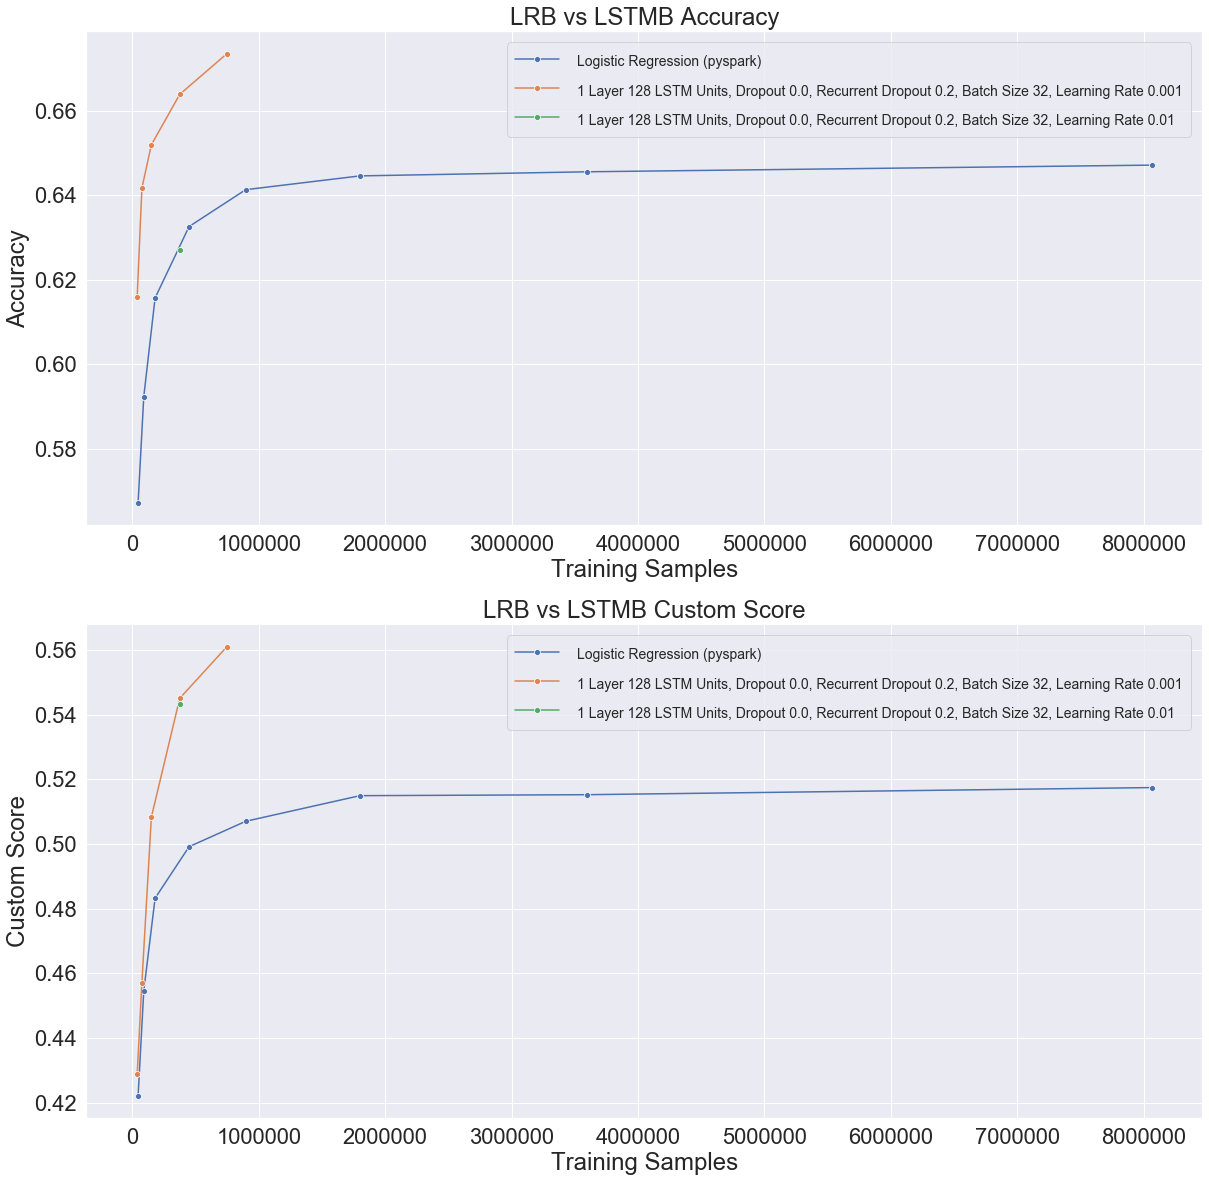

In [8]:
f, a = plt.subplots(2, 1, figsize=(20, 20))
sns.lineplot(data=report_lr, x="train_examples", y="accuracy", marker="o", label="Logistic Regression (pyspark)", ax=a[0])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch32_lr001, x="train_examples", y="accuracy", marker="o", label=report_lstmb128_dr0_rdr20_batch32_lr001.description.values[0], ax=a[0])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch32_lr01, x="train_examples", y="accuracy", marker="o", label=report_lstmb128_dr0_rdr20_batch32_lr01.description.values[0], ax=a[0])


# _ = plt.xticks(rotation=45)
_ = a[0].set_xlabel("Training Samples")
_ = a[0].set_ylabel("Accuracy")
_ = a[0].set_title("LRB vs LSTMB Accuracy")
_ = plt.setp(a[0].get_legend().get_texts(), fontsize='14')




sns.lineplot(data=report_lr, x="train_examples", y="eval_metric", marker="o", label="Logistic Regression (pyspark)", ax=a[1])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch32_lr001, x="train_examples", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr20_batch32_lr001.description.values[0], ax=a[1])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch32_lr01, x="train_examples", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr20_batch32_lr01.description.values[0], ax=a[1])


# _ = plt.xticks(rotation=45)
_ = a[1].set_xlabel("Training Samples")
_ = a[1].set_ylabel("Custom Score")
_ = a[1].set_title("LRB vs LSTMB Custom Score")
_ = plt.setp(a[1].get_legend().get_texts(), fontsize='14')


# Compare Classification Between Logistic Regression (9 mil) and LSTM with 128 Cells (1 mil)

REMINDER: we are using precision for 1-star and 5-star, and recall for 2-star, 3-star, and 4-star reviews to calculate our custom metric. Tradtionally, we have seen that increasing 2-star recall has been challenging, mostly because we have the least amount of samples available to use for training in this category

* F1 and Precision for LSTM exceeds Logistic Regression for all star ratings
* Recall for LSTM for all star ratings exceed Logistic Regression with the exception of 1-star rating
* Generally, we see precison and recall for all star ratings increase for LSTM as we add more training examples
    * Only exception where we see a recall decline is 1-star ratings after 200k examples
    * Starting at around 500k samples for LSTMB, we are seeing 2-star review recall exceeding 3-star and 4-star recall that we have not seen before. 2-star rating was the lowest of all recalls when we trained with Logistic Regression

Best Logistic Regression Model vs Best LSTM


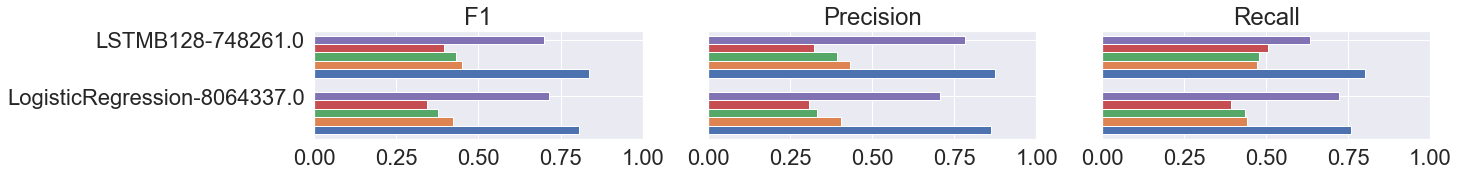

In [5]:
# combine our best LSTM and LR model into one DF so the axis are aligned in our bar graphs
cr_df = report_lstmb128_dr0_rdr20_batch32_lr001[report_lstmb128_dr0_rdr20_batch32_lr001.eval_metric == report_lstmb128_dr0_rdr20_batch32_lr001.eval_metric.max()]. \
                         append(report_lr[report_lr.eval_metric == report_lr.eval_metric.max()], ignore_index = True)
cr_df["display_name"] = cr_df.apply(lambda x: f"{x.model_name}-{str(x.train_examples)}", axis = 1)


print("Best Logistic Regression Model vs Best LSTM")
pu.plot_score_histograms(cr_df, 
                         version=2, 
                         label="display_name")


### Classification Report for LSTMB With 128 Cells

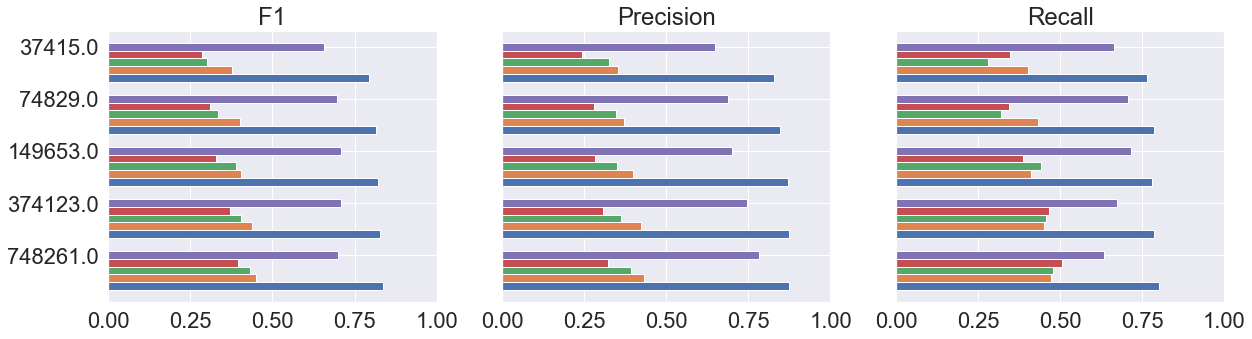

In [6]:
pu.plot_score_histograms(report_lstmb128_dr0_rdr20_batch32_lr001, 
                         version=2, 
                         label="train_examples")